In [13]:
# The '!' symbol tells Colab to run this as a shell command, not Python.
# 'pip' is Python's package manager.
# 'install pyspark' downloads and installs the PySpark library into your Colab environment.
!pip install pyspark


In [14]:
# Install Java 8 (required by Spark) and Spark 3.x
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install PySpark and findspark
!pip install pyspark findspark -qq > /dev/null

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [15]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("UPI Fraud Detection - Offline Model") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# 'spark' is now an active SparkSession object.
print("✅ SparkSession is active and ready.")
print(spark)

✅ SparkSession is active and ready.


In [16]:
# Define the path to the file. It's just the filename since we uploaded it
# to the root directory of our Colab environment.
file_path = "/content/drive/MyDrive/creditcard.csv"

# Use spark.read.csv() to load the data.
# 'header=True' tells Spark that the first row of the file contains the column names.
# 'inferSchema=True' makes Spark automatically read the data and guess the
# data type for each column (e.g., number, text, etc.).
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first 5 rows to confirm it loaded correctly.
print("Data loaded successfully. Here's a preview:")
df.show(5)

# Print the schema (column names and data types) to understand our data.
print("DataFrame Schema:")
df.printSchema()

Data loaded successfully. Here's a preview:
+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|  

Counting null values in each column:
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+

Distribution of Fraudulent vs. Legitimate Transactions:
+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



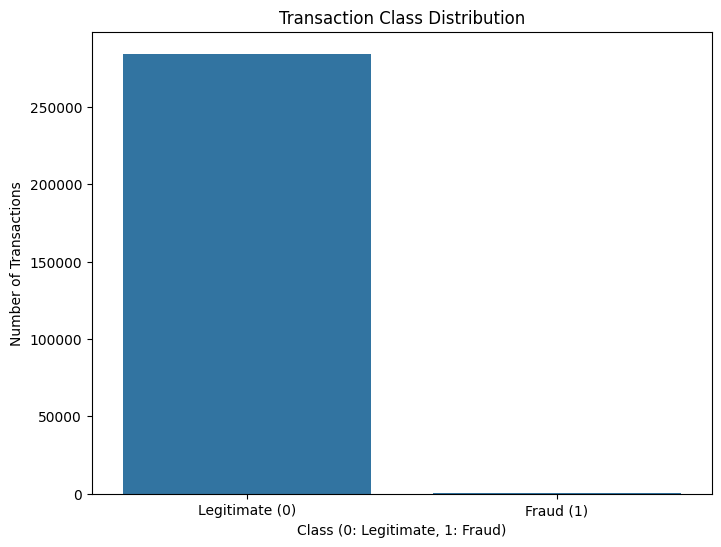

Number of legitimate transactions: 284315
Number of fraudulent transactions: 492
Percentage of fraud: 0.1727%


In [17]:
# Import necessary functions from pyspark.sql
from pyspark.sql.functions import col, count, when

# 1. Check for any missing (null) values in any column.
# This code iterates over all columns, counts the nulls, and shows the result.
print("Counting null values in each column:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# 2. Analyze the Class Imbalance (The Core Challenge)
print("Distribution of Fraudulent vs. Legitimate Transactions:")
# Group the data by the 'Class' column (0 or 1) and count the occurrences of each.
class_distribution = df.groupBy('Class').count()
class_distribution.show()
# You will see a tiny number for Class 1 (fraud) and a huge number for Class 0 (legit).

# 3. Visualize the Imbalance
# To plot, we'll convert the small aggregated DataFrame to a Pandas DataFrame.
# WARNING: Only use .toPandas() on small DataFrames (like this 2-row one).
# Never use it on your full, large dataset.
import matplotlib.pyplot as plt
import seaborn as sns

class_pd = class_distribution.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='count', data=class_pd)
plt.title('Transaction Class Distribution')
plt.xlabel('Class (0: Legitimate, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Legitimate (0)', 'Fraud (1)'])
plt.show()

# 4. Calculate the exact percentage of fraud
legit_count = class_pd[class_pd['Class'] == 0]['count'].iloc[0]
fraud_count = class_pd[class_pd['Class'] == 1]['count'].iloc[0]
print(f"Number of legitimate transactions: {legit_count}")
print(f"Number of fraudulent transactions: {fraud_count}")
print(f"Percentage of fraud: {(fraud_count / (legit_count + fraud_count)) * 100:.4f}%")

In [18]:
# Import the tools we need
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Get a list of all column names *except* our target variable, 'Class'.
# The features 'V1' through 'Amount' will be our model's inputs.
feature_cols = [c for c in df.columns if c != 'Class']

# 2. Create the VectorAssembler
# This tool "assembles" all the individual feature columns into one big vector.
# inputCols: The list of columns to combine.
# outputCol: The name of the new column that will hold the vector.
assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")

# 3. Apply the assembler to our DataFrame
# .transform() runs the assembler and adds the new 'unscaled_features' column.
df_assembled = assembler.transform(df)

# 4. Create the StandardScaler
# This tool scales our features so that features with large values (like 'Amount')
# don't dominate features with small values.
# inputCol: The vector column we just created.
# outputCol: The name for our final, scaled features column.
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features",
                        withStd=True, withMean=False)

# 5. Fit the scaler to the data
# .fit() calculates the required statistics (like standard deviation) from our data.
scaler_model = scaler.fit(df_assembled)

# 6. Apply the scaling
# .transform() uses the calculated statistics to scale the data.
df_scaled = scaler_model.transform(df_assembled)

# Let's look at our final DataFrame, keeping only the columns we need
# 'features': The final, scaled vector of all input features.
# 'Class': The label (0 or 1) we want to predict.
final_df = df_scaled.select("features", "Class")

print("DataFrame ready for modeling:")
final_df.show(5, truncate=False)

DataFrame ready for modeling:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                             

In [19]:
# .randomSplit() shuffles and splits the DataFrame.
# [0.8, 0.2] defines the proportions (80% for training, 20% for testing).
# seed=2025: This ensures that if you run the code again, you get the
# same "random" split, making your results reproducible.
(training_data, test_data) = final_df.randomSplit([0.8, 0.2], seed=2025)

print(f"Total dataset count: {final_df.count()}")
print(f"Training data count: {training_data.count()}")
print(f"Test data count: {test_data.count()}")

Total dataset count: 284807
Training data count: 227798
Test data count: 57009


In [20]:
# Import the RandomForestClassifier class
from pyspark.ml.classification import RandomForestClassifier

# Create an instance of the classifier
# labelCol="Class": Tell the model which column is the target to predict.
# featuresCol="features": Tell the model which column contains the input features.
# numTrees=100: A hyperparameter; 100 trees is a good, robust starting point.
rf = RandomForestClassifier(labelCol="Class", featuresCol="features", numTrees=100)

# Train the model
# .fit(training_data) is the command that starts the learning process.
# Spark will distribute this work across its available cores.
print("Starting model training... (This may take a minute)")
model = rf.fit(training_data)

print("✅ Model training completed successfully!")

Starting model training... (This may take a minute)
✅ Model training completed successfully!


In [21]:
# 1. Make predictions on the test set
# .transform() applies the trained model to the test data.
# It adds a 'prediction' column with the model's guesses.
predictions = model.transform(test_data)

print("Sample predictions on the test set:")
predictions.select("features", "Class", "prediction").show(10)

# 2. Calculate Key Performance Metrics
# We must use metrics that handle imbalanced data well.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluator for Precision for the fraud class (label=1)
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction",
    metricName="precisionByLabel", metricLabel=1)

# Evaluator for Recall for the fraud class (label=1)
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction",
    metricName="recallByLabel", metricLabel=1)

# Evaluator for F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="f1")

# Calculate the metrics
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print("--- Model Evaluation Results ---")
print(f"Precision for Fraud Class (1) = {precision:.4f}")
print(f"Recall for Fraud Class (1)    = {recall:.4f}")
print(f"F1 Score                        = {f1_score:.4f}")
print("--------------------------------")
print("\n**Metric Definitions:**")
print(f"**Precision ({precision:.4f}):** Of all the transactions the model flagged as fraud, {precision*100:.2f}% were *actually* fraud. (Measures: 'How many alarms are real?')")
print(f"**Recall ({recall:.4f}):** Of all the *actual* fraud transactions, the model successfully caught {recall*100:.2f}%. (Measures: 'How many frauds did we catch?')")

# 3. Display a Confusion Matrix
# This shows us exactly where the model was right and wrong.
print("\nConfusion Matrix:")
predictions.groupBy("Class", "prediction").count().show()

Sample predictions on the test set:
+--------------------+-----+----------+
|            features|Class|prediction|
+--------------------+-----+----------+
|[2.10578867609767...|    0|       0.0|
|[8.42315470439071...|    0|       0.0|
|[2.73752527892698...|    0|       0.0|
|[4.63273508741489...|    0|       0.0|
|[5.68562942546373...|    0|       0.0|
|[6.10678716068327...|    0|       0.0|
|[6.73852376351257...|    0|       0.0|
|[6.94910263112234...|    0|       0.0|
|[7.15968149873211...|    0|       0.0|
|[7.15968149873211...|    0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows

--- Model Evaluation Results ---
Precision for Fraud Class (1) = 0.8444
Recall for Fraud Class (1)    = 0.7037
F1 Score                        = 0.9992
--------------------------------

**Metric Definitions:**
**Precision (0.8444):** Of all the transactions the model flagged as fraud, 84.44% were *actually* fraud. (Measures: 'How many alarms are real?')
**Recall (0.7037):** O

In [22]:
# Define a path inside the Colab file system to save our model.
model_path = "/content/spark_random_forest_model"

# .save() will write the model to a directory at that path.
model.save(model_path)

print(f"✅ Model successfully saved to: {model_path}")

# IMPORTANT: To download your model to your computer:
# 1. Click the 'Refresh' button on the left-hand 'Files' panel.
# 2. You will see a new folder named 'spark_random_forest_model'.
# 3. Right-click that folder and select 'Download' to save it permanently.

✅ Model successfully saved to: /content/spark_random_forest_model
